In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.stats import pearsonr, skew
import math
import cartopy.crs as ccrs

In [114]:
THETAO = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/THETAO/thetao_Omon_EC-Earth3_historical_r11i1p1f1_gn_199701-199712.nc')

In [115]:
T = THETAO.thetao

In [125]:
dTdt = T.diff(dim = 'time')

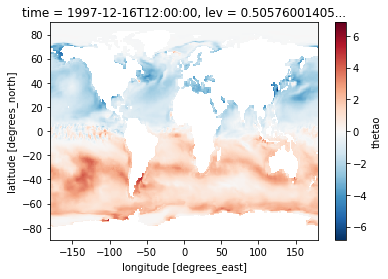

In [135]:
(dTdt[-1][0] - ((T.differentiate(coord = 'time'))[-1][0])).plot()

In [6]:
#U = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/UO/uo_Omon_EC-Earth3_historical_r11i1p1f1_gn_199701-199712.nc').uo

In [7]:
#V = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/VO/vo_Omon_EC-Earth3_historical_r11i1p1f1_gn_199701-199712.nc').vo

In [8]:
#W = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/WO/wo_Omon_EC-Earth3_historical_r11i1p1f1_gn_199701-199712.nc').wo

In [9]:
import os
EC_Earth3_dir = '/g/data/e14/sm2435/CMIP6/EC-Earth3/'
#load in all full DS to get climatology
U=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'shift/UO/*.nc' ))
V=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'shift/VO/*.nc' ))
W=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'shift/WO/*.nc' ))
T=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'THETAO/*.nc' ))



/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  after removing the cwd from sys.path.
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
comb

In [10]:
def get_clim(DS):
    #calc climatology
    clim = DS.groupby('time.month').mean('time')
    #ANOM = DS.groupby('time.month') - clim
    return clim
Ubar = get_clim(U.uo)
Vbar = get_clim(V.vo)
Wbar = get_clim(W.wo)
Tbar = get_clim(T.thetao)

In [11]:
#close full UVWT DS
U.close()
V.close()
W.close()
T.close()

In [12]:
#Now load in Yearly DS and calculate anomalies of all variables
u = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/shift/UO/uo_Omon_EC-Earth3_historical_r11i1p1f1_gn_185001-185012.nc').uo
v = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/shift/VO/vo_Omon_EC-Earth3_historical_r11i1p1f1_gn_185001-185012.nc').vo
w = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/shift/WO/wo_Omon_EC-Earth3_historical_r11i1p1f1_gn_185001-185012.nc').wo
t = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/THETAO/thetao_Omon_EC-Earth3_historical_r11i1p1f1_gn_185001-185012.nc').thetao
ua = u.groupby('time.month') - Ubar
va = v.groupby('time.month') - Vbar
wa = w.groupby('time.month') - Wbar
ta = t.groupby('time.month') - Tbar


In [139]:
#now begin to calculate terms
#dT/dt, time difference of temp anom 
dTdt = ta.diff('time') / 2590000
dTdx = ta.differentiate('lon') / 110e3 / np.cos(ta.lat * np.pi / 180)
dTdy = ta.differentiate('lat') / 110e3 
dTdz = ta.differentiate('lev')
#climatological values
dTbardx = Tbar.differentiate('lon') / 110e3 / np.cos(Tbar.lat * np.pi / 180)
dTbardy = Tbar.differentiate('lat') / 110e3
dTbardz = Tbar.differentiate('lev')

In [140]:
#now get U advection terms, need to ensure data is coreectly goruped to add together
udTdx = ua*dTdx
ubardTdx = Ubar*dTdx.groupby('time.month')
udtbardx = ua.groupby('time.month')*dTbardx
#get v
vdTdy = va*dTdy
vbardTdy = Vbar*dTdy.groupby('time.month')
vdtbardy = va.groupby('time.month')*dTbardy
#get w
wdTdz = wa*dTdz
wbardTdz = Wbar*dTdz.groupby('time.month')
wdtbardz = wa.groupby('time.month')*dTbardz


In [141]:
uadv = udtbardx + udTdx + ubardTdx
vadv = vdtbardy + vdTdy + vbardTdy
wadv = wdtbardz + wdTdz + wbardTdz


In [ ]:
test = uadv.sel(lat=slice(-20,20),lon=slice(40,110))
 

In [ ]:
test.integrate('lev').integrate('time').plot()

In [ ]:
q = dTdt.integrate('lev').integrate('time') + uadv.integrate('lev').integrate('time') + vadv.integrate('lev').integrate('time') + wadv.integrate('lev').integrate('time')

In [142]:
uadv_ = uadv.integrate('lev')
vadv_ = vadv.integrate('lev')
wadv_ = wadv.integrate('lev')


In [18]:
Q = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/EC-Earth3_HFDS.nc')

In [ ]:
ua.lev[-1].values

In [ ]:
(3986*1026*61.11283875)

In [77]:
qpch = (Q.hfds/(3986*1026*61.11283875))[0:12]

In [78]:
qpch

<xarray.DataArray 'hfds' (time: 12, lat: 180, lon: 360)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-3.87520167e-08, -3.83915761e-08, -3.80052292e-08, ...,
         -3.96750934e-08, -3.93940525e-08, -3.90862702e-08],
        [-5.02123889e-08, -5.07624733e-08, -5.12990148e-08, ...,
         -4.84790945e-08, -4.90708771e-08, -4.96485804e-08],
        [-1.65616605e-08, -1.67207954e-08, -1.68812413e-08, ...,
         -1.60920077e-08, -1.62472773e-08, -1.64038241e-08]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-5.73855239e-08, -5.79028310e-08, -5.85161182e-08, ...,
         -5.64197826e-08, -5.66429570e-08, -5.69652201e-08],
        [-5.16787679e-08, -5.23678203e-08, -5.30429638e-08, ...,
         -4.95263244e-08, -5.02582012e-08, -5.09756184e-08],
        [-1.60502047e-08, -1.62161662e-08, -1.63833658e-08, ...,
         -1.55596354e-08, -1.57219500e-08, -1.58854689e-08]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-8.18609180e-08, -8.18261015e-08, -8.18685137e-08, ...,
         -8.24370829e-08, -8.21655703e-08, -8.19737878e-08],
        [-7.50435660e-08, -7.55799334e-08, -7.61062751e-08, ...,
         -7.33729308e-08, -7.39401926e-08, -7.44970237e-08],
        [-2.45689211e-08, -2.47536995e-08, -2.49398440e-08, ...,
         -2.40226754e-08, -2.42034215e-08, -2.43855016e-08]],

       ...,

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-4.36150955e-08, -4.38331398e-08, -4.40555787e-08, ...,
         -4.29878391e-08, -4.31924008e-08, -4.34015028e-08],
        [-2.89184019e-08, -2.90007609e-08, -2.90772419e-08, ...,
         -2.86353021e-08, -2.87357498e-08, -2.88300903e-08],
        [-1.74102439e-08, -1.73869310e-08, -1.73634742e-08, ...,
         -1.74793318e-08, -1.74564434e-08, -1.74334147e-08]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-4.01677482e-08, -4.02613658e-08, -4.03555553e-08, ...,
         -3.98903879e-08, -3.99822575e-08, -4.00747098e-08],
        [-2.45745291e-08, -2.43474645e-08, -2.41226044e-08, ...,
         -2.52692054e-08, -2.50353693e-08, -2.48038194e-08],
        [-1.29026025e-08, -1.28300659e-08, -1.27568542e-08, ...,
         -1.31162095e-08, -1.30456685e-08, -1.29744677e-08]],

       [[            nan,             nan,             nan, ...,
          

In [ ]:
plt.pcolormesh(uadv_.sel(lat=slice(-20,20),lon=slice(40,110))[0])
plt.colorbar()

In [ ]:
uadv_[0]

In [144]:
DT_ = (dTdt/2500000).integrate('lev')
DT_.load()

#create fucntion to plot first month of all terms


/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'thetao' (time: 11, lat: 180, lon: 360)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-8.49569924e-13, -8.54018383e-13, -8.60217411e-13, ...,
         -8.46916062e-13, -8.45999970e-13, -8.46890518e-13],
        [-2.53314932e-13, -2.65423872e-13, -2.77307546e-13, ...,
         -2.15606128e-13, -2.28408939e-13, -2.40977763e-13],
        [-9.59234022e-14, -9.84702861e-14, -1.01031564e-13, ...,
         -8.83698310e-14, -9.08735094e-14, -9.33911891e-14]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-9.04314344e-13, -9.18039827e-13, -9.33496250e-13, ...,
         -8.73711630e-13, -8.82131958e-13, -8.92339112e-13],
        [-7.35190958e-14, -7.76490373e-14, -8.16293291e-14, ...,
         -6.02161055e-14, -6.48044074e-14, -6.92379300e-14],
        [-1.30049862e-13, -1.31113873e-13, -1.32181506e-13, ...,
         -1.26879025e-13, -1.27931967e-13, -1.28989266e-13]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-1.59920895e-13, -1.75724861e-13, -1.92110373e-13, ...,
         -1.16062126e-13, -1.30083495e-13, -1.44705248e-13],
        [ 2.41831297e-13,  2.50126691e-13,  2.58293805e-13, ...,
          2.16168654e-13,  2.24854261e-13,  2.33408158e-13],
        [-9.47234720e-15, -8.37570041e-15, -7.26807890e-15, ...,
         -1.26985440e-14, -1.16332603e-14, -1.05579025e-14]],

       ...,

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-6.62085940e-13, -6.57855232e-13, -6.53331621e-13, ...,
         -6.72994815e-13, -6.69658962e-13, -6.66022456e-13],
        [-5.99935348e-13, -6.05516080e-13, -6.11041876e-13, ...,
         -5.82849901e-13, -5.88602803e-13, -5.94296886e-13],
        [-1.89701801e-13, -1.90762647e-13, -1.91832650e-13, ...,
         -1.86567126e-13, -1.87604173e-13, -1.88649147e-13]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-4.19734489e-13, -4.18452996e-13, -4.17033552e-13, ...,
         -4.22731902e-13, -4.21875701e-13, -4.20875065e-13],
        [-2.49363595e-13, -2.54727934e-13, -2.59935156e-13, ...,
         -2.32314695e-13, -2.38159805e-13, -2.43842515e-13],
        [ 8.12691970e-14,  8.08931034e-14,  8.05167502e-14, ...,
          8.23968494e-14,  8.20214199e-14,  8.16456654e-14]],

       [[            nan,             nan,             nan, ...,
        

In [ ]:
plt.pcolormesh(q)

In [145]:
uadv_.load()

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (time: 12, lat: 180, lon: 360)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.60388740e-07,  1.82306063e-07,  2.07782061e-07, ...,
          1.60142718e-07,  1.02974850e-07,  1.26095162e-07],
        [-3.46851228e-08, -3.50410315e-08, -3.54171429e-08, ...,
         -2.82788319e-08, -3.27688209e-08, -3.44072667e-08],
        [ 1.22375785e-08,  1.20017947e-08,  1.17862289e-08, ...,
          1.28913393e-08,  1.26705508e-08,  1.24346783e-08]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.82754517e-07,  1.93238042e-07,  2.06142859e-07, ...,
          1.72460553e-07,  1.49932492e-07,  1.62009428e-07],
        [-2.27149782e-08, -2.38509934e-08, -2.50803050e-08, ...,
         -1.76305413e-08, -1.97145884e-08, -2.11516560e-08],
        [ 1.53009275e-09,  1.25461735e-09,  9.55470455e-10, ...,
          2.45119413e-09,  2.15429159e-09,  1.88278763e-09]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 2.68450188e-07,  2.62603458e-07,  2.49064140e-07, ...,
          2.70035427e-07,  3.09648841e-07,  3.01939445e-07],
        [ 2.68357053e-08,  2.55264950e-08,  2.41324383e-08, ...,
          3.29435961e-08,  3.01159230e-08,  2.83584823e-08],
        [ 5.69844159e-10, -8.62004200e-13, -5.84043413e-10, ...,
          2.31993239e-09,  1.73840799e-09,  1.16686377e-09]],

       ...,

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 3.86880944e-08,  4.26026691e-08,  4.56703285e-08, ...,
          2.81185853e-08,  3.04176668e-08,  3.53192288e-08],
        [ 5.21669612e-08,  5.11992231e-08,  4.98145232e-08, ...,
          6.04792423e-08,  5.63595728e-08,  5.45091612e-08],
        [ 2.12605056e-08,  2.12774856e-08,  2.13692545e-08, ...,
          2.09297464e-08,  2.10130602e-08,  2.10230929e-08]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 2.86727248e-08,  3.11323692e-08,  3.26958579e-08, ...,
          1.81561734e-08,  2.30680423e-08,  2.66307515e-08],
        [ 7.12278209e-08,  7.07952367e-08,  6.97715068e-08, ...,
          7.97760458e-08,  7.50850922e-08,  7.34654654e-08],
        [ 2.72818528e-08,  2.73153754e-08,  2.74606067e-08, ...,
          2.67671478e-08,  2.69007996e-08,  2.69289254e-08]],

       [[            nan,             nan,             nan, ...,
                 

In [146]:
vadv_.load()
wadv_.load()

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (time: 12, lat: 180, lon: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

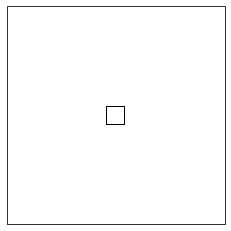

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
ax.contourf(uadv_[0],transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()

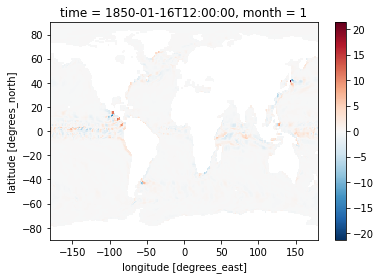

In [30]:
uadv_[0].plot()

In [57]:
#zoom in on IO of all terms
uadv_i = uadv_.sel(lat=slice(-20,20),lon=slice(40,110)).integrate('time')
vavd_i = vadv_.sel(lat=slice(-20,20),lon=slice(40,110)).integrate('time')
wadv_i = wadv_.sel(lat=slice(-20,20),lon=slice(40,110)).integrate('time')
DT_i= DT_.sel(lat=slice(-20,20),lon=slice(40,110)).integrate('time')
qpch_i = qpch.sel(lat=slice(-20,20),lon=slice(40,110)).integrate('time')
#resi = DT_i +uadv_i+vadv_i+wadv_i-qpch_i

Text(0.5, 1.0, 'Q/(rho*c*h), year 1 inetgrated')

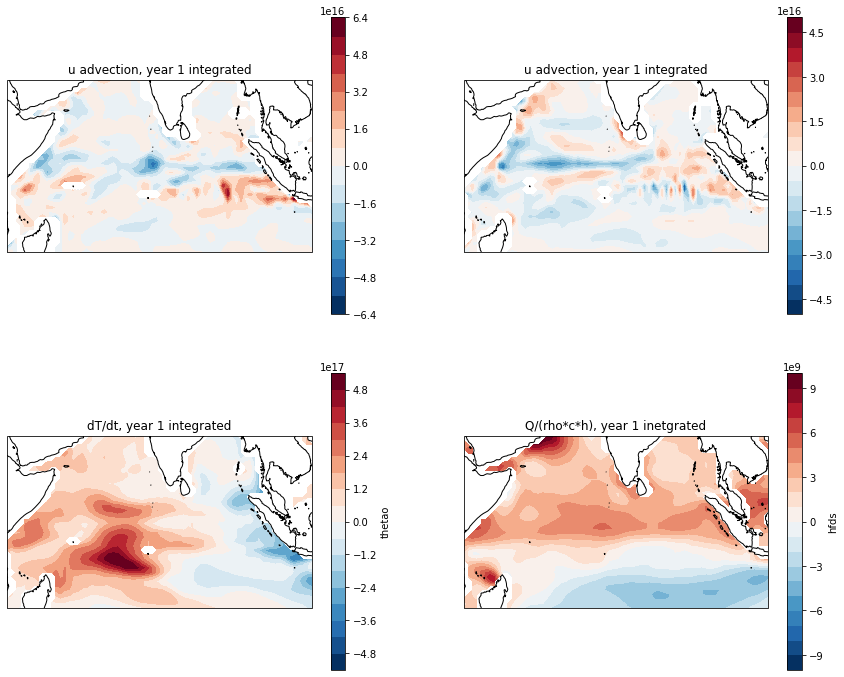

In [80]:
#now make plots of these
#yearly mean of heat budget
#fig = plt.figure(figsize = (15,12))
#((ax1, ax2, ax3), (ax4, ax5, ax6),) = fig.subplots(2, 3)
#ax1.contourf(uadv_i.lon, uadv_i.lat, uadv_i)
#ax2.contourf(vavd_i.lon, vavd_i.lat, vavd_i)
#ax3.contourf(wadv_i.lon, wadv_i.lat, wadv_i)
#ax4.contourf(DT_i.lon, DT_i.lat, DT_i)
#ax5.contourf(qpch_i.lon, qpch_i.lat, qpch_i)
#ax6.contourf(resi.lon, resi.lat, resi)


fig = plt.figure(1, figsize=(15,12))
ax = plt.subplot(2, 2 , 1, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=uadv_i.plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('u advection, year 1 integrated')

ax = plt.subplot(2, 2 , 2, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=vavd_i.plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('u advection, year 1 integrated')


ax = plt.subplot(2, 2 , 3, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=DT_i.plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('dT/dt, year 1 integrated')


ax = plt.subplot(2, 2 , 4, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=qpch_i.plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('Q/(rho*c*h), year 1 inetgrated')




In [79]:
qpch_i = qpch.sel(lat=slice(-20,20),lon=slice(40,110)).integrate('time')


In [82]:
resi = DT_i +uadv_i+vavd_i-qpch_i

Text(0.5, 1.0, 'residual (including w advection)')

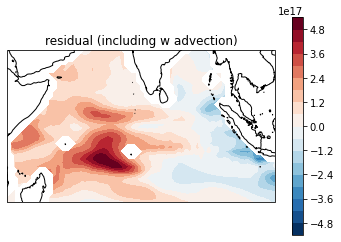

In [86]:
ax = plt.subplot(1, 1 , 1, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=resi.plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('residual (including w advection)')

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Q/(rho*c*h), month 1 ')

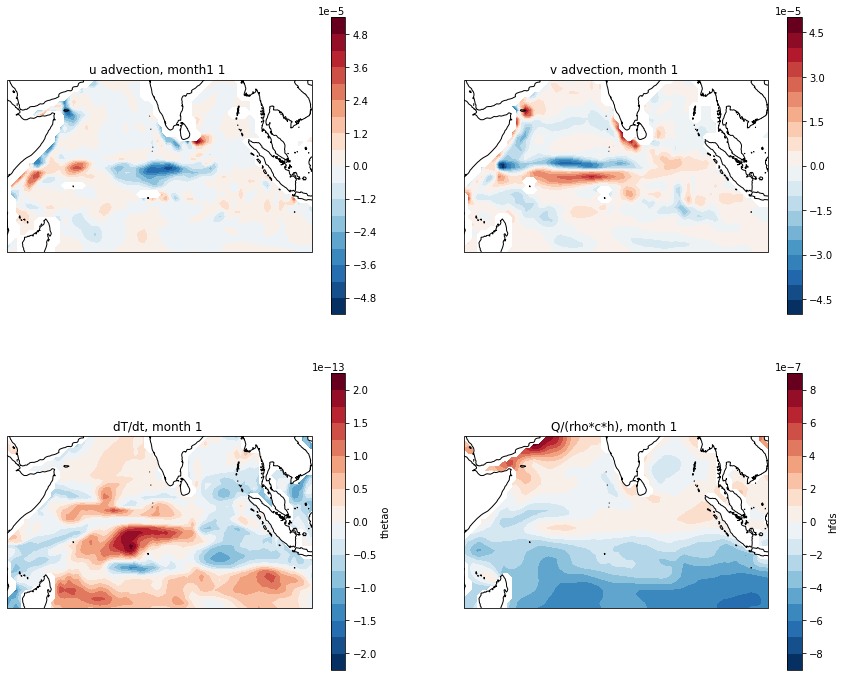

In [150]:
fig = plt.figure(1, figsize=(15,12))
ax = plt.subplot(2, 2 , 1, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=uadv_.sel(lat=slice(-20,20),lon=slice(40,110))[6].plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('u advection, month1 1 ')

ax = plt.subplot(2, 2 , 2, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=vadv_.sel(lat=slice(-20,20),lon=slice(40,110))[6].plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('v advection, month 1 ')


ax = plt.subplot(2, 2 , 3, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=(dTdt/2500000).sel(lat=slice(-20,20),lon=slice(40,110))[0][6].plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('dT/dt, month 1 ')


ax = plt.subplot(2, 2 , 4, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=qpch.sel(lat=slice(-20,20),lon=slice(40,110))[6].plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('Q/(rho*c*h), month 1 ')

In [95]:
resi_1= DT_.sel(lat=slice(-20,20),lon=slice(40,110))[0] +uadv_.sel(lat=slice(-20,20),lon=slice(40,110))[0]+vadv_.sel(lat=slice(-20,20),lon=slice(40,110))[0]-qpch.sel(lat=slice(-20,20),lon=slice(40,110))[0]

Text(0.5, 1.0, 'residual month 1(including w advection)')

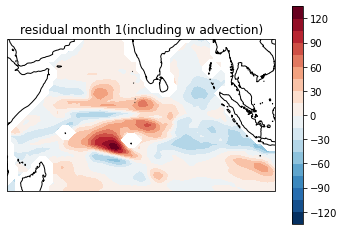

In [96]:
ax = plt.subplot(1, 1 , 1, projection=ccrs.PlateCarree(central_longitude=130.0))
fill=resi_1.plot.contourf(transform=ccrs.PlateCarree(),   
                        levels = 21, cmap = 'RdBu_r', add_colorbar=True)
ax.coastlines()
ax.set_title('residual month 1(including w advection)')

In [104]:
dTdz[:, 0:-1]

<xarray.DataArray 'thetao' (time: 12, lev: 19, lat: 180, lon: 360)>
dask.array<getitem, shape=(12, 19, 180, 360), dtype=float32, chunksize=(1, 19, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 35.74 41.18 47.21 53.85
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [100]:
dTdz

<xarray.DataArray 'thetao' (time: 12, lev: 20, lat: 180, lon: 360)>
dask.array<_trim, shape=(12, 20, 180, 360), dtype=float32, chunksize=(1, 20, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85 61.11
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12